In [50]:
from neo4j import GraphDatabase
from graphdatascience import GraphDataScience

# Configure Neo4j connection settings
neo4j_url = "neo4j+ssc://34.126.85.60:7687"
neo4j_user = "neo4j"
neo4j_password = "neo4j123"
neo4j_db = "neo4j"

# Create a Neo4j driver and GDS driver
driver = GraphDatabase.driver(neo4j_url, auth=(neo4j_user, neo4j_password),database=neo4j_db)
gds = GraphDataScience(neo4j_url,auth=(neo4j_user,neo4j_password),database=neo4j_db)

print(f"GDS Versoin: {gds.version()}")

GDS Versoin: 2.3.3


In [51]:
data_location = 'https://raw.githubusercontent.com/zhongjie526/neo4j_data_catalog/master/data/'

gds.run_cypher("MATCH (n) DETACH DELETE n;")
gds.run_cypher("CREATE CONSTRAINT imp_uniq_tbl_name IF NOT EXISTS FOR (n: Table) REQUIRE (n.name) IS UNIQUE;")
gds.run_cypher("CREATE CONSTRAINT imp_uniq_ds_name IF NOT EXISTS FOR (n: Datasource) REQUIRE (n.name) IS UNIQUE;")
gds.run_cypher("CREATE CONSTRAINT imp_uniq_col_name IF NOT EXISTS FOR (n: Column) REQUIRE (n.name) IS UNIQUE;")
gds.run_cypher("CREATE CONSTRAINT imp_uniq_team_name IF NOT EXISTS FOR (n: Team) REQUIRE (n.name) IS UNIQUE;")
gds.run_cypher("CREATE CONSTRAINT imp_uniq_user_name IF NOT EXISTS FOR (n: User) REQUIRE (n.name) IS UNIQUE;")

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row 
WITH row WHERE row.name is not null
MERGE (n: Table { name: replace(row.name, '"', '') }) 
SET n._uid = row._uid
""",params={'path':data_location+'table_n0.csv'})

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row 
WITH row WHERE NOT row.`name` IS NULL
MERGE (n: Datasource { name: replace(row.name, '"', '') }) 
SET n._uid = row._uid;
""",params={'path':data_location+'datasource_n1.csv'})


gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
WITH row WHERE NOT row.`name` IS NULL
MERGE (n: `Column` { `name`: replace(row.name, '"', '')})
SET n.`_uid` = row.`_uid`;
""",params={'path':data_location+'column_n2.csv'})


gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
with row WHERE NOT row.`name` IS NULL
MERGE (n: `Team` { `name`: replace(row.name, '"', '') })
SET n.`_uid` = row.`_uid`;
""",params={'path':data_location+'team_n3.csv'})

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
with row WHERE NOT row.`name` IS NULL
MERGE (n: `User` { `name`: replace(row.name, '"', '')})
SET n.`_uid` = row.`_uid`;
""",params={'path':data_location+'user_n4.csv'})

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
with row WHERE NOT row.`name` IS NULL
MERGE (n: `Table` { `name`: replace(row.name, '"', '')})
SET n.`_uid` = row.`_uid`;
""",params={'path':data_location+'table_n5.csv'})

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
MATCH (source: `Table` { `name`: replace(row._from_name, '"', '')  })
MATCH (target: `Column` { `name`: replace(row._to_name, '"', '') })
MERGE (source)-[r: `HAS_COLUMN`]->(target)
SET r.`_uid` = row.`_uid`;
""",params={'path':data_location+'table_has_column_column_n1.csv'})

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
MATCH (source: `Table` { `name`: replace(row._from_name, '"', '') })
MATCH (target: `Team` { `name`: replace(row._to_name, '"', '') })
MERGE (source)-[r: `OWNED_BY`]->(target)
SET r.`_uid` = row.`_uid`;
""",params={'path':data_location+'table_owned_by_team_n2.csv'})

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
MATCH (source: `Team` { `name`: replace(row._from_name, '"', '') })
MATCH (target: `User` { `name`: replace(row._to_name, '"', '') })
MERGE (source)-[r: `HAS_USER`]->(target)
SET r.`_uid` = row.`_uid`;
""",params={'path':data_location+'team_has_user_user_n3.csv'})

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
MATCH (source: `Table` { `name`: replace(row._from_name, '"', '') })
MATCH (target: `Datasource` { `name`: replace(row._to_name, '"', '') })
MERGE (source)-[r: `FROM_SOURCE`]->(target)
SET r.`_uid` = row.`_uid`;
""",params={'path':data_location+'table_from_source_datasource_n4.csv'})

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
MATCH (source: `Table` { `name`: replace(row._from_name, '"', '') })
MATCH (target: `Column` { `name`: replace(row._to_name, '"', '')})
MERGE (source)-[r: `HAS_COLUMN`]->(target)
SET r.`_uid` = row.`_uid`;
""",params={'path':data_location+'table_has_column_column_n5.csv'})

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
MATCH (source: `Table` { `name`: replace(row._from_name, '"', '') })
MATCH (target: `Team` { `name`: replace(row._to_name, '"', '') })
MERGE (source)-[r: `OWNED_BY`]->(target)
SET r.`_uid` = row.`_uid`;
""",params={'path':data_location+'table_owned_by_team_n6.csv'})

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
MATCH (source: `Table` { `name`: replace(row._from_name, '"', '')  })
MATCH (target: `Table` { `name`: replace(row._to_name, '"', '') })
MERGE (source)-[r: `DERIVED_FROM`]->(target)
SET r.`_uid` = row.`_uid`;
""",params={'path':data_location+'table_derived_from_table_n7.csv'})

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
MATCH (source: `User` { `name`: replace(row._from_name, '"', '')  })
MATCH (target: `Table` { `name`: replace(row._to_name, '"', '') })
MERGE (source)-[r: `HAS_ROLE`]->(target)
SET r.`role` = row.`role`;
""",params={'path':data_location+'user_has_role_table_n8.csv'})

gds.run_cypher("""
LOAD CSV with HEADERS FROM $path as row
MATCH (source: `User` { `name`: replace(row._from_name, '"', '')  })
MATCH (target: `Table` { `name`: replace(row._to_name, '"', '')})
MERGE (source)-[r: `HAS_ROLE`]->(target)
SET r.`role` = row.`role`;
""",params={'path':data_location+'user_has_role_table_n9.csv'})


""


In [61]:
%pip install matplotlib
%pip install networkx

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Check Data Lineage

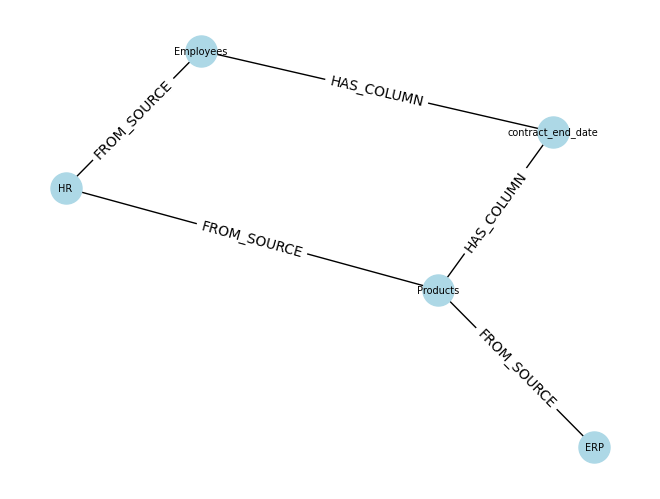

In [116]:
import networkx as nx
import matplotlib.pyplot as plt

with driver.session() as session:
    result = session.run("match (c:Column {name:'contract_end_date'})-[r1:HAS_COLUMN]-(t:Table)-[r2:FROM_SOURCE]-(s:Datasource) return c,r1,t,r2,s")

    # Create a Network object
    G = nx.Graph()

    # Add the node to the network
    for record in result:
        node = record["c"]
        G.add_node(node.id, label=node["name"], color="lightblue")
        node = record["t"]
        G.add_node(node.id, label=node["name"], color="lightblue")
        node = record["s"]
        G.add_node(node.id, label=node["name"], color="lightblue")
        rel = record["r1"]
        G.add_edge(rel.start_node.id, rel.end_node.id,label=rel.type)
        rel = record["r2"]
        G.add_edge(rel.start_node.id, rel.end_node.id,label=rel.type)


# Visualize the network
pos = nx.spring_layout(G)
labels = nx.get_node_attributes(G, "label")
edge_labels = nx.get_edge_attributes(G, "label")

nx.draw(G, pos, labels = labels,with_labels=True, node_color="lightblue", node_size=500, font_size=7)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

## Finding Critical Data Assets by Degree Centrality

**Degree Centrality measures the number of connections or relationships a node has in a graph. In the context of data quality analysis, you can use Degree Centrality to identify metadata elements (nodes) that have a high number of relationships, indicating their significance or importance in the data ecosystem. Nodes with high Degree Centrality may represent critical tables, columns, or data entities that require careful attention and quality assessment.**

In [59]:
gds.run_cypher("""

CALL gds.graph.drop('myGraph',false) YIELD graphName;
""")

gds.run_cypher("""
CALL gds.graph.project(
  'myGraph',
  ['Team','Table'],
  {
    OWNED_BY: {
      orientation: 'NATURAL'
    }
  }
)
""")

gds.run_cypher("""
CALL gds.degree.stream('myGraph')
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score AS owners
ORDER BY owners DESC, name DESC
LIMIT 5
""")


,name,owners
0,Orders_Summary,4.0
1,Products,3.0
2,Invoices,3.0
3,Customers,3.0
4,Customer_Summary,3.0
